### Make superresolution work on small sample
- Get a high and low res version of two images.
- Modify your network so that you are only using a content loss

### Train superresolution on large sample

### Add GAN for superresolution to improve model

In [1]:
import torch
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.autograd import Variable
from torch.utils.serialization import load_lua
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
import pdb
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import bcolz
import pdb
from b_iter import BcolzArrayIterator
%matplotlib inline
import os
GPU = False
DTYPE = torch.cuda.FloatTensor
BATCH_SIZE = 2

### Create Images

In [2]:
data_path = "data/sample/train"
sm_path = "data/sample/train/sm"
lg_path = "data/sample/train/lg"
hr_path = 'data/sample_224.bc'
lr_path = 'data/sample_56.bc'
hr_act_path = 'data/arr_224_vgg_act.bc'
hr_s = 224
lr_s = 56

In [3]:
def vizBcolzImg(img):
    plt.imshow(img[:, :, :] / 255.)


imgs = glob.glob(os.path.join(data_path,'*.JPEG'))
szs = []
flush_num = 3
for i, img in enumerate(imgs):
    new_path = os.path.join(sm_path, os.path.basename(img))
    Image.open(img).resize((lr_s,lr_s)).save(new_path)
    #szs.append(Image.open(img).size)


#### Save images as hr and lr bc_arrays
chunk_len = 2
flush_num = 3
arr_hr = bcolz.carray(np.empty((0, hr_s, hr_s, 3), 'float32'), 
                   chunklen=chunk_len, mode='w', rootdir=hr_path)
arr_lr = bcolz.carray(np.empty((0, lr_s, lr_s, 3), 'float32'), 
                   chunklen=chunk_len, mode='w', rootdir=lr_path)

imgs = glob.glob(os.path.join(lg_path, 'wrap','*.JPEG'))

for i, img in enumerate(imgs):
    print(i)
    arr_hr.append(np.array(Image.open(img)))
arr_hr.flush()

for i, img in enumerate(imgs):
    new_path = os.path.join(sm_path, 'wrap', os.path.basename(img))
    arr_lr.append(np.array(Image.open(new_path).resize((lr_s, lr_s))))
arr_lr.flush()


#### Save lr images as bc_array, all but last

arr_lr = bcolz.carray(np.empty((0, lr_s, lr_s, 3), 'float32'), 
                   chunklen=chunk_len, mode='w', rootdir=lr_path)

for i, img in enumerate(imgs):
    new_path = os.path.join(sm_path, 'wrap', os.path.basename(img))
    arr_lr.append(np.array(Image.open(new_path).resize((lr_s, lr_s))))
    if i == (len(imgs) -2): break
arr_lr.flush()

In [4]:
arr_hr = bcolz.open(hr_path)
arr_lr = bcolz.open(lr_path)

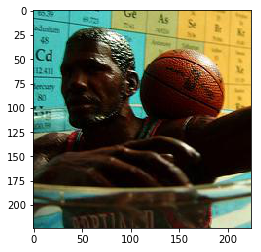

In [5]:
vizBcolzImg(arr_hr[6])

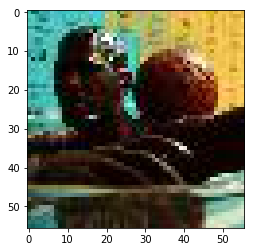

In [6]:
vizBcolzImg(arr_lr[6])

### Precompute VGG activations for high res images

In [7]:
#Replace max pooling with avg pooling in vgg16
def get_avg_pool_vgg(stop_layer):
    vgg = models.vgg.vgg16(pretrained = True)

    layers = []
    for i, layer in enumerate(vgg.features):
        if isinstance(layer,nn.MaxPool2d):
            #replace MaxPool layers with AvgPool
            layers.append(nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)))
        else:
            layers.append(layer)
        if stop_layer and i == stop_layer:
            pass
            #break
    
    #create a new model with our modified layers
    vgg_mod = nn.Sequential(*layers)
    
    #load the pretrained vgg weights into our model
    vgg_mod.load_state_dict(vgg.features.state_dict())
    for param in vgg_mod.parameters():param.requires_grad = False
    return vgg_mod
    '''
    if stop_layer:
        ls = [l for i,l in enumerate(vgg_mod.children()) if i < stop_layer+1]
        mod = nn.Sequential(*ls)
        for param in mod.parameters():param.requires_grad = False
        return mod
    else:
        for param in vgg_mod.parameters():param.requires_grad = False
        return vgg_mod
    '''
#helper functions

def data_gen(inp, targ, batch_size=1, shuffle=True):
    #labels = np.array(targ)
    #pdb.set_trace()
    if shuffle:
        ix = np.random.permutation(len(inp))
        inp = inp[ix]
        targs = targ[ix]
    for idx in range(0,len(inp),batch_size):
        yield(inp[idx:idx+batch_size],targ[idx:idx+batch_size])



m = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]

def toTens(imgs):
    img = torch.from_numpy(imgs.transpose((0, 3, 1, 2)))
    # backward compatibility
    return img.float().div(255)


def norm(img):
    img[:,0, :, :] = (img[:,0, :, :] - m[0]) / std[0]
    img[:,1, :, :] = (img[:,1, :, :] - m[1]) / std[1]
    img[:,2, :, :] = (img[:,2, :, :] - m[2]) / std[2]
    return img


def toTensAndNorm(imgs):
    return norm(toTens(imgs))

def deNormTrans(img):
    m = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
    img[0, :, :] = img[0, :, :] * std[0] + m[0]
    img[1, :, :] = img[1, :, :] * std[1] + m[1]
    img[2, :, :] = img[2, :, :] * std[2] + m[2]
    return pilTrans(img)

def denormAndPlot(img):
    img = img.clone().squeeze().cpu()
    img = deNormTrans(img)
    plt.imshow(cCrop(img))
    #plt.imshow(cCrop(pilTrans(img)))
    plt.show()

mse = torch.nn.MSELoss()
noRed = torch.nn.MSELoss(size_average=False)

pilTrans = transforms.ToPILImage()
toTensAndNormTrans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(m, std)])
inputTrans = transforms.Compose([transforms.Scale((256,256)),transforms.ToTensor()])
styleImgTrans = transforms.ToTensor()
cCrop = transforms.CenterCrop(256)

https://github.com/svishnu88/pytorch/blob/master/TransferLearning.ipynb

In [8]:
vgg = get_avg_pool_vgg(7)

#### Precompute activations sequentially, with iterator batch 4
bc_iter = BcolzArrayIterator(X=arr_hr, batch_size=4)
batch_size=4
act_c = 512 
act_w_h = 7
arr_hr_act = bcolz.carray(np.empty((0, act_c, act_w_h, act_w_h), 'float32'), 
                   chunklen=2, mode='w', rootdir=hr_act_path)

for i in range(len(arr_hr) // batch_size):
    #pdb.set_trace()
    inp = bc_iter.next()
    inp = Variable(toTensAndNorm(inp))
    res = vgg(inp).data.numpy()
    arr_hr_act.append(res)
    print(i)
    #arr_hr_act.flush()
arr_hr_act.flush()


#### Precompute activations sequentially, no iterator

act_c = 512 
act_w_h = 7
arr_hr_act = bcolz.carray(np.empty((0, act_c, act_w_h, act_w_h), 'float32'), 
                   chunklen=16, mode='w', rootdir=hr_act_path)


for i in range(len(arr_hr)):
    inp = arr_hr[i]
    inp = Variable(toTensAndNorm(np.expand_dims(inp, 0)))
    res = vgg(inp).data.numpy()
    arr_hr_act.append(res)
    print(i)
    #arr_hr_act.flush()
arr_hr_act.flush()


### Train for super res

In [9]:
#Our transform network. This is the 'output' of this whole process. When training is complete, 
# its weights will contain the knowledge of how to take an input image and transform it into an output 
#image that's a blend of the input image and the specific style image the network was trained on.

class ResidualBlock(nn.Module):
    def __init__(self, num):
        super(ResidualBlock, self).__init__()
        self.c1 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=1)
        self.b1 = nn.BatchNorm2d(num)
        self.b2 = nn.BatchNorm2d(num)

    def forward(self, x):
        h = F.relu(self.b1(self.c1(x)))
        h = self.b2(self.c2(h))
        return h + x

class FastTransNet(nn.Module):
    def __init__(self):
        super(FastTransNet, self).__init__()
        self.ref_padding = torch.nn.ReflectionPad2d(40)
        self.cs1 = nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4) 
        self.cs2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) 
        self.cs3 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1) 
        
        self.b1s1 =nn.BatchNorm2d(32)
        self.b1s2 =nn.BatchNorm2d(64)
        self.b1s3 =nn.BatchNorm2d(64)
        
        self.rs1 =  ResidualBlock(64)
        self.rs2 =  ResidualBlock(64)
        self.rs3 =  ResidualBlock(64)
        self.rs4 =  ResidualBlock(64)
        self.rs5 =  ResidualBlock(64)
        
        self.ds1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.ds2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.ds3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.ds4 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)

        self.b2s1 = nn.BatchNorm2d(64)
        self.b2s2 = nn.BatchNorm2d(64)
        self.b2s3 = nn.BatchNorm2d(64)
        self.b2s4 = nn.BatchNorm2d(64)
        self.d3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, h):
        h = F.relu(self.b1s1(self.cs1(h)))
        h = F.relu(self.b1s2(self.cs2(h)))
        h = F.relu(self.b1s3(self.cs3(h)))
        h = self.rs1(h)
        h = self.rs2(h);
        h = self.rs3(h);
        h = self.rs4(h);
        h = self.rs5(h);
        h = F.relu(self.b2s1(self.ds1(h)))
        h = F.relu(self.b2s2(self.ds2(h)))
        h = F.relu(self.b2s3(self.ds3(h)))
        h = F.relu(self.b2s4(self.ds4(h)))      
        h = self.d3(h)
        return (F.tanh(h) + 1.0) / 2

In [16]:
f = FastTransNet()

In [17]:
opt = optim.Adam(f.parameters(), lr=0.0001)
arr_hr_act = bcolz.open(hr_act_path)

In [26]:
report_num = 10
epochs = 300
batch_size = 2
num_b = len(arr_hr_act) // batch_size

for epoch in range(epochs):
    total_loss = 0.
    train_iter = BcolzArrayIterator(X=arr_lr, y=arr_hr_act, batch_size=batch_size, shuffle=True)
    for i in range(num_b):
        opt.zero_grad()
        inp, targ = train_iter.next()
        inp = Variable(toTens(inp))
        targ = Variable(torch.from_numpy(targ))
        inter = f(inp)
        inter = norm(inter)
        out = vgg(inter)
        l = mse(out, targ)
        total_loss += l.data[0]
        l.backward()
        opt.step()
        #if (i+1) % report_num == 0: print(l.data[0])
    print('Epoch {} loss: {}'.format(epoch, total_loss))
    #inputs = Variable(norm(inputs))
    

Epoch 0 loss: 0.04276453098282218
Epoch 1 loss: 0.042785687488503754
Epoch 2 loss: 0.042784847784787416
Epoch 3 loss: 0.04365265113301575
Epoch 4 loss: 0.04332992935087532
Epoch 5 loss: 0.04222150961868465
Epoch 6 loss: 0.042325455346144736
Epoch 7 loss: 0.042802757932804525
Epoch 8 loss: 0.04256312840152532
Epoch 9 loss: 0.04356368724256754
Epoch 10 loss: 0.04320890479721129
Epoch 11 loss: 0.044187657767906785
Epoch 12 loss: 0.044116400415077806
Epoch 13 loss: 0.04426010977476835
Epoch 14 loss: 0.0477321264334023
Epoch 15 loss: 0.04581163031980395
Epoch 16 loss: 0.0451431431574747
Epoch 17 loss: 0.043995447806082666
Epoch 18 loss: 0.04891616408713162
Epoch 19 loss: 0.047792206634767354
Epoch 20 loss: 0.04646778164897114
Epoch 21 loss: 0.04813923838082701
Epoch 22 loss: 0.044861534144729376
Epoch 23 loss: 0.0447157685412094
Epoch 24 loss: 0.04423303669318557
Epoch 25 loss: 0.04488717159256339
Epoch 26 loss: 0.044543285737745464
Epoch 27 loss: 0.04457183659542352
Epoch 28 loss: 0.045911

KeyboardInterrupt: 

In [28]:
torch.save(f.state_dict(), 'models/trans_net_samp_56_224_bc_opt.pt')
torch.save(opt, 'models/trans_net_samp_56_224_bc_opt.pt')

#### Train Sequentially, no iterator

report_num = 10
epochs = 100
for epoch in range(epochs):
    total_loss = 0.
    for i in range(len(arr_hr_act)):
        opt.zero_grad()
        sm_img = Variable(transforms.ToTensor()(arr_lr[i]).unsqueeze(0))
        targ = Variable(torch.from_numpy(arr_hr_act[i]))
        
        inter = f(sm_img)
        inter = norm(inter)
        out = vgg(inter)
        l = mse(out, targ)
        total_loss += l.data[0]
        l.backward()
        opt.step()
        #if (i+1) % report_num == 0: print(l.data[0])
    print('Epoch {} loss: {}'.format(epoch, total_loss))
    #inputs = Variable(norm(inputs))
    
    #res = vgg(inputs).data.numpy()

In [38]:
from b_iter import BcolzArrayIterator

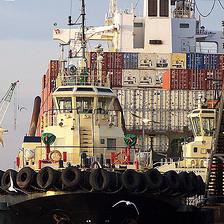

In [45]:
imgs = glob.glob(os.path.join(lg_path, 'wrap','*.JPEG'))
basename = os.path.basename(imgs[4])        
sm_name = os.path.join(sm_path, 'wrap', basename)
sm_img = Image.open(sm_name)

Image.open(imgs[4])

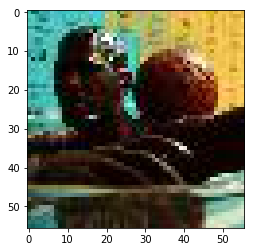

In [6]:
vizBcolzImg(arr_lr[6])

In [46]:
res = f(Variable(transforms.ToTensor()(sm_img).unsqueeze(0)))

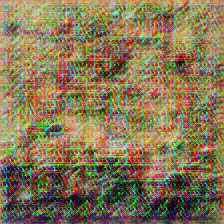

In [47]:
pilTrans(res.squeeze().data)

In [25]:
j = toTens(np.expand_dims(arr_lr[0], 0))

In [26]:
res = f(Variable(j))

In [76]:
res.data[0, 1, :4, :4]


 0.4410  0.4033  0.4092  0.4058
 0.4200  0.3976  0.4557  0.4062
 0.4143  0.3966  0.3580  0.3784
 0.3751  0.4123  0.4090  0.3839
[torch.FloatTensor of size 4x4]

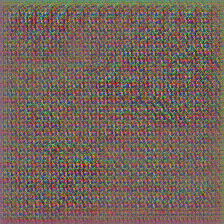

In [27]:
pilTrans(res.data.squeeze())

In [84]:
res.size()

torch.Size([1, 3, 224, 224])

In [75]:
arr_lr_t[0]

(56, 56, 3)

In [74]:
ups = f(Variable(torch.from_numpy(arr_lr_t[0][:])))

ValueError: Expected 4D tensor as input, got 3D tensor instead.

In [29]:
l = [tup for tup in next(data_iter)]

In [36]:
l[1].shape

(13, 128, 112, 112)

In [ ]:
#Wrapper for our feature extractor and transformNetwork
class WrapperModel(nn.Module):
    def __init__(self, transNet, vggNet, test_img):
        super(WrapperModel, self).__init__()
        
        self.transNet = transNet
        self.vggNet = vggNet
 
        #take an image we'll use for visualizing how the network is doing and convert it to a variable
        self.img_arr = Variable(inputTrans(inp_img).unsqueeze(0).type(DTYPE))
        
        #convert our style image to variable
        self.style_img_arr = Variable(styleImgTrans(style_img).unsqueeze(0).type(DTYPE))
        
        
    def forward(self, batch):
        inter = self.transNet(batch)
        out = self.vggNet(inter)      
        return out

In [ ]:
#create our various networks
vgg = get_avg_pool_vgg()
transNet = FastTransNet()
featExt = FeatureExtractor(vgg, [7, 12, 19, 26])

if GPU:
    transNet.cuda()
    featExt.cuda()    
    wrapM = WrapperModel(transNet, featExt, img, style_img)
    wrapM.cuda()
else:
    wrapM = WrapperModel(transNet, featExt, img, style_img)
    
transNet_opt = optim.Adam(transNet.parameters(), lr =0.0001)

In [21]:
ds = datasets.ImageFolder(tr_data_path, inputTrans)
def train(model, transNet_opt= transNet_opt):
    report_num = 100
    for epoch in range(10):
        dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE,shuffle=True, drop_last=True)
        #for keeping track of our loss
        run_comb = 0.0
        run_style = 0.0
        run_cont = 0.0
        
        for i, (batch, _) in enumerate(iter(dl)):
            transNet_opt.zero_grad()
            batch = Variable(batch.type(DTYPE)) 
             
            #content target is the vgg activations produced by the training images
            content_targ = model.vggNet(model.ref_pad(batch))[0]
            

            #put the training images through transformNet. 
            #Then put that result through vgg and take 4 layers of activations
            out = model(batch)
            
            
            #get losses and combine them for total loss
            style_l = style_loss(out, model.style_grams)
            cont_l = mse(out[0], content_targ) /10.0
            comb_l = cont_l + style_l 
            
            run_comb += comb_l.data[0]
            run_style += style_l.data[0]
            run_cont += cont_l.data[0]
            
            if (i+1) % report_num == 0:
                print('Losses for iter {}:'.format(i))
                print('style {}:'.format(run_style/ report_num))
                print('content {}:'.format(run_cont/report_num))
                print('combined {}:'.format(run_comb/report_num))
                print('========')
                run_comb = 0.0; run_style = 0.0; run_cont = 0.0
                denormAndPlot(model.transNet(model.img_arr).data) #let's see how our image looks

            #adjust parameters
            comb_l.backward()
            transNet_opt.step()
    return model.transNet

Losses for iter 99:
style 0.07284081805497408:
content 0.041596672125160696:
combined 0.1144374904036522:


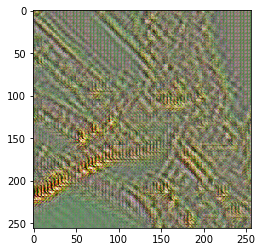

Losses for iter 199:
style 0.05002357985824347:
content 0.04148757802322507:
combined 0.09151115790009498:


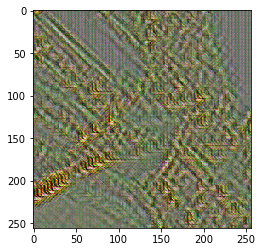

Losses for iter 299:
style 0.03557174557819962:
content 0.040488381087779995:
combined 0.07606012683361768:


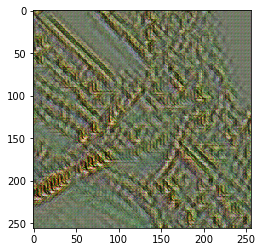

Losses for iter 399:
style 0.03037085499614477:
content 0.0405364240705967:
combined 0.07090727876871825:


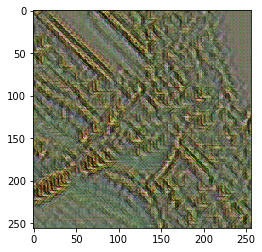

Losses for iter 499:
style 0.026757099609822036:
content 0.039412269201129675:
combined 0.06616936866194009:


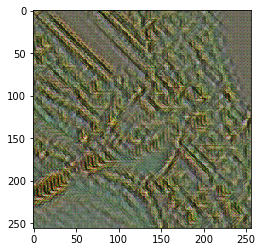

Losses for iter 599:
style 0.023077231757342817:
content 0.04125683505088091:
combined 0.06433406703174115:


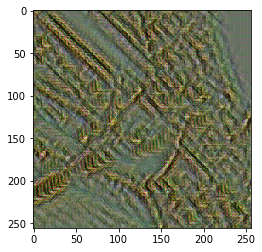

Losses for iter 699:
style 0.02053048531524837:
content 0.03953171519562602:
combined 0.060062200538814066:


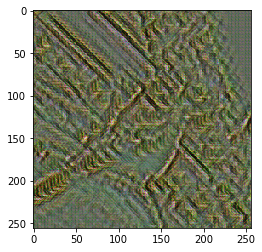

Losses for iter 799:
style 0.019264139365404845:
content 0.0386536442860961:
combined 0.0579177837818861:


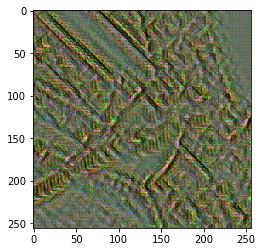

Losses for iter 899:
style 0.018312197662889957:
content 0.038514598794281485:
combined 0.05682679634541273:


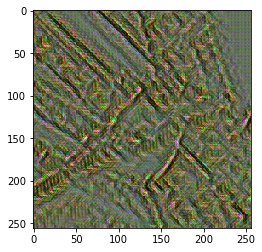

Losses for iter 999:
style 0.01659847367554903:
content 0.03866093020886183:
combined 0.055259403884410856:


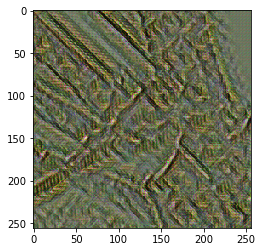

Losses for iter 1099:
style 0.01604689600877464:
content 0.03782526638358832:
combined 0.05387216255068779:


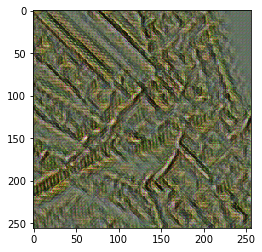

Losses for iter 1199:
style 0.014871264472603798:
content 0.038066651560366156:
combined 0.05293791607022286:


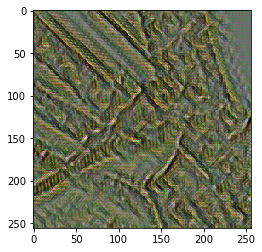

Losses for iter 1299:
style 0.014267694987356663:
content 0.036760402061045166:
combined 0.05102809701114893:


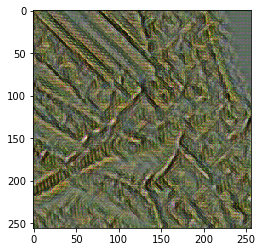

Losses for iter 1399:
style 0.01309077269397676:
content 0.036036428920924665:
combined 0.04912720177322626:


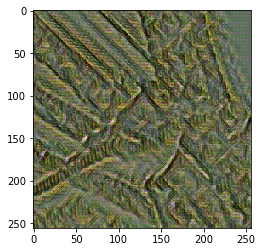

Losses for iter 1499:
style 0.012835625987499953:
content 0.03612300762906671:
combined 0.04895863357931376:


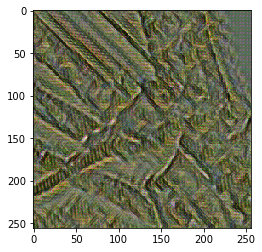

Losses for iter 1599:
style 0.012909270180389286:
content 0.035202103294432165:
combined 0.04811137355864048:


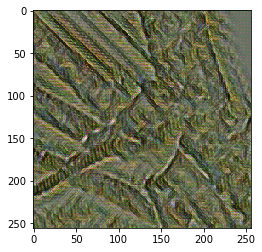

Losses for iter 1699:
style 0.012052521603181958:
content 0.036001184191554784:
combined 0.048053705766797065:


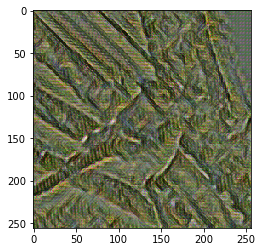

Losses for iter 1799:
style 0.011500864308327436:
content 0.03519306693226099:
combined 0.046693931184709075:


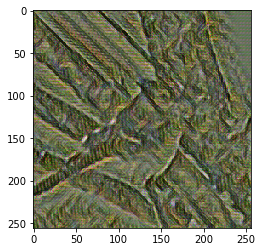

Losses for iter 1899:
style 0.013672781586647033:
content 0.03494377709925175:
combined 0.048616558760404584:


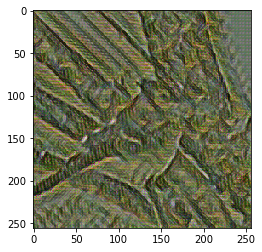

Losses for iter 1999:
style 0.011774210995063185:
content 0.03592283884063363:
combined 0.0476970500126481:


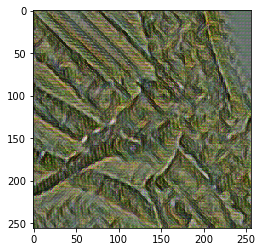

Losses for iter 2099:
style 0.011108882185071707:
content 0.034823652114719154:
combined 0.045932534337043765:


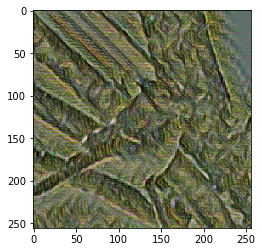

Losses for iter 2199:
style 0.012260176595300437:
content 0.0344750651717186:
combined 0.046735241636633874:


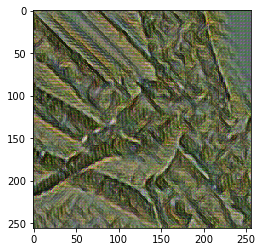

KeyboardInterrupt: 

In [18]:
train(wrapM, transNet_opt=transNet_opt)

In [22]:
torch.save(transNet.state_dict(),'models/olives_high_content_stylex100_tanh.pt')
torch.save(transNet_opt,'olives_stylex_high_content_10_tanh_ADAM.pt')